In [1]:
import numpy as np
import pandas as pd
import main
fake_data_wc = pd.read_csv('fake_data/fake_wc_res.csv', delimiter=';')
fake_data_wc.head()

,ID,X,Y,WC
0,0,348202,6460000,1.700000e+38
1,1,348202,6460000,1.700000e+38
2,2,348202,6460000,1.700000e+38
3,3,348202,6460000,1.700000e+38
4,4,348202,6460000,1.700000e+38


In [2]:
# Конвертируем форматы
fake_data_wc['WC'] = fake_data_wc['WC'].astype('float64')
fake_data_wc['ID'] = fake_data_wc['ID'].astype('str')
fake_data_wc['WELL_NAME'] = 'fake_' + fake_data_wc['ID']
del fake_data_wc['ID']
fake_data_wc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5399 entries, 0 to 5398
Data columns (total 4 columns):
X            5399 non-null int64
Y            5399 non-null int64
WC           5399 non-null float64
WELL_NAME    5399 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 168.8+ KB


In [3]:
# Удаляем значения зашедшие за край
fake_data_wc = fake_data_wc.drop(fake_data_wc[fake_data_wc['WC'] > 1].index)
fake_data_wc.head()

,X,Y,WC,WELL_NAME
24,348302,6460000,0.39,fake_24
25,348302,6460000,0.39,fake_25
26,348302,6460000,0.39,fake_26
27,348302,6460000,0.39,fake_27
28,348302,6460000,0.39,fake_28


In [4]:
fake_las_out = pd.read_csv('fake_data/fake_las_out.csv', delimiter=';')
fake_las_out.head()

,WELL_NAME,DEPTH,APS
0,fake_0,2584.999314,0.380130
1,fake_0,2585.121187,0.380130
2,fake_0,2585.121309,0.364062
3,fake_0,2585.243182,0.364062
4,fake_0,2585.243304,0.309785


In [5]:
fake_bottom = pd.read_csv('fake_data/fake_bottom_res.csv', delimiter=';')
fake_bottom['ID'] = fake_bottom['ID'].astype('str')
fake_bottom['WELL_NAME'] = 'fake_' + fake_bottom['ID']
fake_bottom = fake_bottom.rename(columns={'DEPTH': 'DEPTH_BOTTOM'})
del fake_bottom['ID']
del fake_bottom['X']
del fake_bottom['Y']
fake_bottom.head()

,DEPTH_BOTTOM,WELL_NAME
0,2601.50,fake_0
1,2600.09,fake_1
2,2598.85,fake_2
3,2598.79,fake_3
4,2599.31,fake_4


In [6]:
fake_top = pd.read_csv('fake_data/fake_top_res.csv', delimiter=';')
fake_top['ID'] = fake_top['ID'].astype('str')
fake_top['WELL_NAME'] = 'fake_' + fake_top['ID']
fake_top = fake_top.rename(columns={'DEPTH': 'DEPTH_TOP'})
del fake_top['ID']
del fake_top['X']
del fake_top['Y']
fake_top.head()

,DEPTH_TOP,WELL_NAME
0,2585.02,fake_0
1,2582.98,fake_1
2,2581.22,fake_2
3,2580.52,fake_3
4,2580.87,fake_4


In [7]:
fake_data = pd.merge(fake_data_wc, fake_las_out, on='WELL_NAME')
fake_data = pd.merge(fake_data, fake_top, on='WELL_NAME') 
fake_data = pd.merge(fake_data, fake_bottom, on='WELL_NAME')
fake_data.head()

,X,Y,WC,WELL_NAME,DEPTH,APS,DEPTH_TOP,DEPTH_BOTTOM
0,348302,6460000,0.39,fake_24,2588.656453,0.274434,2588.27,2603.89
1,348302,6460000,0.39,fake_24,2588.771455,0.274434,2588.27,2603.89
2,348302,6460000,0.39,fake_24,2588.771570,0.274434,2588.27,2603.89
3,348302,6460000,0.39,fake_24,2588.886333,0.191055,2588.27,2603.89
4,348302,6460000,0.39,fake_24,2588.886448,0.101674,2588.27,2603.89


In [9]:
from scipy import interpolate
well_name_list = fake_data['WELL_NAME'].value_counts().index.tolist()
x_values = []
y_values = []
count_val = 100
well_count = 0
min_count_val_in_data = 10
for well_name in well_name_list:
    if well_count%500 == 0:
        print(well_count, ' of ', len(well_name_list))
    data_well =  fake_data[fake_data['WELL_NAME'] == well_name]
    bottom = data_well['DEPTH_BOTTOM'].tolist()[0]
    top = data_well['DEPTH_TOP'].tolist()[0]
    # print('top = ', top)
    # print('bottom =', bottom)    
    data_well_by_bound = data_well[(data_well['DEPTH'] >= top) & (data_well['DEPTH'] <= bottom)]
    x_arr = data_well_by_bound['DEPTH']
    y_arr = data_well_by_bound['APS']
    
    if (len(x_arr) < min_count_val_in_data):
            continue
    
    # print ('length of array depth', len(x_arr))
    f_spline = interpolate.interp1d(x_arr, y_arr, kind = 'slinear')
    h_start = data_well_by_bound['DEPTH'].min()
    h_end = data_well_by_bound['DEPTH'].max()
    # print(h_start, h_end, top, bottom)
    h_step = (h_end - h_start)/count_val
    x_temp = []
    i = 0
    while(i < count_val):
        x_temp.append(float(f_spline(h_start + i * h_step)))
        i = i + 1
    x_values.append(x_temp)  
    y_values.append(data_well['WC'].tolist()[0])
    well_count = well_count + 1
print('end fill')

0  of  5322
500  of  5322
1000  of  5322
1500  of  5322
2000  of  5322
2500  of  5322
3000  of  5322
3500  of  5322
4000  of  5322
4500  of  5322
5000  of  5322
end fill


In [12]:
from sklearn.model_selection import train_test_split, StratifiedKFold
x_train, x_hold, y_train, y_hold = train_test_split(x_values, y_values, test_size=0.3, random_state=17)

In [13]:
# сохраняем для анализа в матлабе
save_x_train = pd.DataFrame(x_train, columns=['x' + str(z) for z in range(0, count_val)])
save_y_train = pd.DataFrame(y_train, columns=['wc'])
save_xy_train = pd.merge(save_y_train, save_x_train, left_index = True, right_index = True)
save_x_hold = pd.DataFrame(x_hold, columns=['x' + str(z) for z in range(0, count_val)])
save_y_hold = pd.DataFrame(y_hold, columns=['wc'])
save_xy_hold = pd.merge(save_y_hold, save_x_hold, left_index = True, right_index = True)
save_xy_train.to_csv('matlab_prepare/data_fake_aps_train_spectrogram.csv', sep = ',', index = False, header = False)
save_xy_hold.to_csv('matlab_prepare/data_fake_aps_hold_spectrogram.csv', sep = ',', index = False, header =False)

In [14]:
col_names = ['wc']
x_names = ['x' + str(z) for z in range(0, 129)]
col_names.extend(x_names)
spectr_train = pd.read_csv("matlab_prepare/data_fake_aps_train_spectrogram_out.csv", delimiter=',', names=col_names)
spectr_hold = pd.read_csv("matlab_prepare/data_fake_aps_hold_spectrogram_out.csv", delimiter=',', names=col_names)
spectr_hold.head(n=2)

,wc,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128
0,0.36,0.29112,0.29130,0.29184,0.29283,0.29441,0.29694,0.30142,0.33911,0.41955,...,0.43950,0.47838,0.49012,0.62068,0.65032,0.86567,0.42641,0.37876,0.44196,0.69784
1,0.23,0.22665,0.22813,0.23280,0.24132,0.25506,0.27637,0.30924,0.35973,0.44425,...,0.53933,0.42038,0.45706,0.68891,0.57291,0.53057,0.45517,0.46877,0.73415,2.98740


In [15]:
y_train = spectr_train['wc'].values.tolist()
x_train = spectr_train[x_names].values.tolist() 
y_hold = spectr_hold['wc'].values.tolist()
x_hold = spectr_hold[x_names].values.tolist()

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

forest_reg =  RandomForestRegressor(n_estimators=10 ,
                           oob_score=True,
                           random_state=17)

from sklearn.model_selection import GridSearchCV, cross_val_score
forest_params = { 
    'max_depth': [1, 10, 20, 40, 60],
    'n_estimators': [1, 10, 30, 50, 70, 100],
    'max_features': ['auto', 'sqrt', 'log2']
}

print('Start', param, ' learning')
forest_grid = GridSearchCV(forest_reg, forest_params, cv=5, n_jobs=-1, verbose=True)
value_fit = forest_grid.fit(x_train, y_train) 
y_predict = forest_grid.predict(x_hold)

D:\libs\Anaconda\3.3\envs\aind\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Start APS  learning
Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done 525 out of 525 | elapsed: 34.3min finished


In [17]:
data_well_for_analize = pd.DataFrame({'y_hold':y_hold, 'y_predict':y_predict})
data_well_for_analize.to_csv('fake_data/result_spectrogram.csv',index=False, sep = ';')

Обучение на классификаторе

In [10]:
y_values_r = [int(10 * y_val) for y_val in y_values]

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score

x_train, x_hold, y_train, y_hold = train_test_split(x_values, y_values, test_size=0.3, random_state=17)

D:\libs\Anaconda\3.3\envs\aind\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
# сохраняем для анализа
save_x_train = pd.DataFrame(x_train, columns=['x' + str(z) for z in range(0, count_val)])
save_y_train = pd.DataFrame(y_train, columns=['wc'])
save_xy_train = pd.merge(save_y_train, save_x_train, left_index = True, right_index = True)
save_x_hold = pd.DataFrame(x_hold, columns=['x' + str(z) for z in range(0, count_val)])
save_y_hold = pd.DataFrame(y_hold, columns=['wc'])
save_xy_hold = pd.merge(save_y_hold, save_x_hold, left_index = True, right_index = True)
save_xy_train.to_csv('fake_data/data_fake_aps_train.csv', sep = ';', index = False, header = True)
save_xy_hold.to_csv('fake_data/data_fake_aps_hold.csv', sep = ';', index = False, header =True)

In [12]:
# обучаем дерево
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

forest = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=17)
# print(np.mean(cross_val_score(forest, x_hold, y_hold, cv=6))) # 0.949


forest_params = { 
    'max_depth': [1, 10, 20, 40, 60],
    'n_estimators': [1, 10, 30, 50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2']
}

forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)
 
forest_grid.fit(x_train, y_train)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 525 out of 525 | elapsed: 22.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=17,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 10, 20, 40, 60], 'n_estimators': [1, 10, 30, 50, 100, 200, 500], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [13]:
print('forest_grid.best_params_ = ', forest_grid.best_params_)
print('forest_grid.best_score_ = ', forest_grid.best_score_)
print('forest_grid.best_estimator_ = ', forest_grid.best_estimator_)
#print('accuracy_score: ', accuracy_score(y_hold, forest_grid.predict(x_hold)))

forest_grid.best_params_ =  {'max_depth': 40, 'max_features': 'auto', 'n_estimators': 500}
forest_grid.best_score_ =  0.747710257386
forest_grid.best_estimator_ =  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=17,
           verbose=0, warm_start=False)


In [14]:
y_predict = forest_grid.predict(x_hold)

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def data_analize_func(predict_for_analize, file_name = ''):
    # подготовка данных
    data_for_analize = predict_for_analize.sort_values(by=['y_hold'])
    data_for_analize['x_axis'] = [x for x in range(len(predict_for_analize['y_hold']))]
    data_for_analize.head()
    if file_name != '':
        data_for_analize.to_csv('AllGisParams/' + file_name, index=False, sep = ';')
    
    # построение графиков
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_predict'], color = 'blue')
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_hold'], color = 'red')
    plt.show()
    
    # regression metrics
    print('MSE                      = '+ str(mean_squared_error(data_for_analize['y_hold'], 
                                                                data_for_analize['y_predict'])))
    print('MAE                      = '+ str(mean_absolute_error(data_for_analize['y_hold'], 
                                                                 data_for_analize['y_predict'])))
    print('r2_score                 = '+ str(r2_score(data_for_analize['y_hold'], 
                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')
    print('explained_variance_score = '+ str(explained_variance_score(data_for_analize['y_hold'], 
                                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')

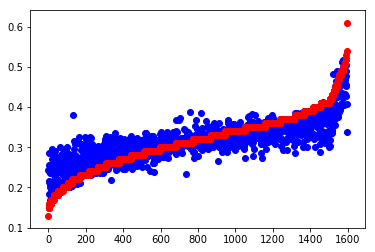

MSE                      = 0.00120860255254
MAE                      = 0.0246764308078
r2_score                 = 0.755595368026    (best_value is 1)
explained_variance_score = 0.755608697904    (best_value is 1)


In [17]:
predict_for_analize_fake = pd.DataFrame({'y_hold':y_hold, 'y_predict':y_predict})
data_analize_func(predict_for_analize_fake)

In [105]:
y_uniq = []
for y in  y_calc_val:
    is_uniq = True
    for y_un in y_uniq:
        if (y_un == y):
            is_uniq = False
    if (is_uniq):
        y_uniq.append(y)
y_uniq

[3, 4, 2, 1, 5]

In [21]:
import pickle
# Dump the trained decision tree classifier with Pickle
decision_tree_pkl_filename = 'fake_data\\decision_forest_grid_fake_data_regressor.pkl'
# Open the file to save as pkl file
decision_tree_model_pkl = open(decision_tree_pkl_filename, 'wb')
pickle.dump(forest_grid, decision_tree_model_pkl)
# Close the pickle instances
decision_tree_model_pkl.close()

In [19]:
import pickle
# Dump the trained decision tree classifier with Pickle
decision_tree_pkl_filename = 'fake_data\\decision_forest_grid_fake_data_regressor.pkl'
# Open the file to save as pkl file
decision_tree_model_pkl = open(decision_tree_pkl_filename, 'wb')
pickle.dump(forest_grid, decision_tree_model_pkl)
# Close the pickle instances
decision_tree_model_pkl.close()